In [13]:
import MDAnalysis as mda
atomistic_system = mda.Universe
from modules.distances import *
from modules.dssp import dssp
from modules.input import res_list, show_fasta
from typing import Tuple
%reload_ext autoreload
%autoreload 2
import input
from ipywidgets import IntProgress
from IPython.display import display

In [14]:
atomistic_system, reference_structure, energy_like_terms, is_aligned = input.read_files()
is_aligned = input.align_traj(is_aligned)
show_fasta(atomistic_system)


Aligned file found, reading this instead
Trajectory allready aligned, delete md250ns_center_po_aligned.xtc to rerun alignement
----5----10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95---100--105--110--115--120--125--130--135--140--145--150--155--160--165--170--
TTAPEAPSVNDTEVGSKKVSGKGHEVGNTVTVTFPDGKTATSKVDEKGNWTVDVPEGTELKVGNEITATETDMSGNKSESGKGKVTDTTAPEAPSVNDTEVGSKKVSGKGHEVGNTVTVTFPDGKTATSKVDEKGNWTVDVPEGTELKVGNEITATETDMSGNKSESGKGKVTD
--------E--EE----EEEEE------EEEEE-----EEEEEE----EEEEE-------------EEEEE-----E---EE--EE---------E--E-----EEEEE------EEEEE-----EEEEEE----EEEEE-----------EEEEEEE-----E---EEEEE--


In [4]:
from scipy.optimize import minimize
from scipy.spatial.transform import Rotation

def alignment_error(params, points1, points2):
    """
    Compute alignment error (objective function) for optimization.
    
    params: array-like, parameters to optimize (rotation and translation)
    points1, points2: numpy arrays, 3D point clouds
    """
    rotation = Rotation.from_euler('xyz', params[:3])
    translation = params[3:]
    
    # Apply rotation and translation to points1
    aligned_points1 = rotation.apply(points1) + translation
    
    # Compute sum of squared distances between aligned points1 and points2
    error = np.sum((aligned_points1 - points2) ** 2)
    
    return error

def least_squares_alignment(points1, points2):
    """
    Perform least squares alignment of two 3D point clouds.
    
    points1, points2: numpy arrays, 3D point clouds
    """
    # Initial guess for rotation angles and translation vector
    initial_guess = np.zeros(6)
    
    # Perform optimization to minimize alignment error
    result = minimize(alignment_error, initial_guess, args=(points1, points2))
    
    # Extract optimized rotation and translation parameters
    rotation_params = result.x[:3]
    translation = result.x[3:]
    
    # Convert rotation parameters to Rotation object
    rotation = Rotation.from_euler('xyz', rotation_params)
    
    return rotation, translation

In [5]:

# vetor from PCA
sele_residues_vectorA = "(resid 10 to 80) and name CA"
sele_residues_vectorB = "(resid 97 to 167) and name CA"



In [43]:
angles = []

f = IntProgress(min=0, max=len(atomistic_system.trajectory)) # instantiate the bar
display(f)
for ts in atomistic_system.trajectory:
    #if atomistic_system.trajectory.time > 10*100:
    #    break
    CAs_A = atomistic_system.select_atoms(sele_residues_vectorA).positions
    CAs_B = atomistic_system.select_atoms(sele_residues_vectorB).positions
    f.value += 1
    rotation, translation = least_squares_alignment(CAs_A, CAs_B)
    euler_angles = rotation.as_euler('zyx', degrees=True)
    angles.append(euler_angles)


IntProgress(value=0)

[array([32., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45.,
       46., 47., 48., 49., 50., 51., 52.]), array([ 1,  5,  4,  7,  8,  7,  8,  8, 10,  8,  5,  5,  7,  3,  8,  2,  1,
        1,  1,  2], dtype=int64)]


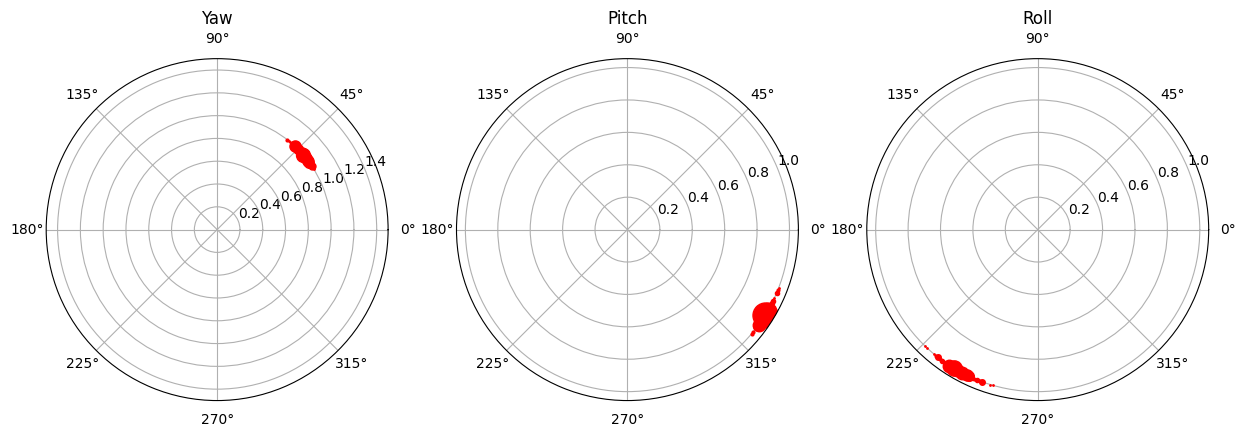

In [50]:
rounded_angles = np.round(angles)
unique_rounded_angles_y, counts_y = np.unique(rounded_angles.T[0], return_counts=True)
unique_rounded_angles_p, counts_p = np.unique(rounded_angles.T[1], return_counts=True)
unique_rounded_angles_r, counts_r = np.unique(rounded_angles.T[2], return_counts=True)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': 'polar'})
print([unique_rounded_angles_y, counts_y])
# Plot the rotation angles
for i, angle in enumerate(unique_rounded_angles_y):
    axs[0].plot(np.radians(angle), 1,  marker='o', markersize=counts_y[i], color='r', linestyle='None')
    axs[0].set_title('Yaw')
    axs[0].set_rmax(1.5)  # Set the maximum radius of the plot

for i, angle in enumerate(unique_rounded_angles_p):
    axs[1].plot(np.radians(angle), 1,  marker='o', markersize=counts_p[i], color='r', linestyle='None')
    axs[1].set_title('Pitch')

for i, angle in enumerate(unique_rounded_angles_r):
    axs[2].plot(np.radians(angle), 1,  marker='o', markersize=counts_r[i], color='r', linestyle='None')
    axs[2].set_title('Roll')
#ax.legend(loc='upper right')
#yaw.set_theta_direction(-1)
#yaw.set_theta_zero_location('N')

plt.show()